In [37]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [38]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [39]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
orig = cv2.imread('cropped_panda.jpg')[..., ::-1]
print(orig.shape)

orig = cv2.resize(orig, (224, 224))

print(orig.shape)
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = torch.from_numpy(img).to(device).float()
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()
label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))

(100, 100, 3)
(224, 224, 3)
torch.Size([1, 3, 224, 224])
label=388


In [40]:

#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
target=288
target=torch.Tensor([float(target)]).to(device).long()
e = 0.01
for epoch in range(epochs):
    # 梯度清零
    optimizer.zero_grad()

    # forward + backward
    output = model(img)
    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())

    print("epoch={} loss={} label={}".format(epoch,loss,label))
    #如果定向攻击成功
    if label == target:
        break
    loss.backward()
    # print(img.grad.data>0)
    img.data = img.data - e*torch.sign(img.grad.data)

epoch=0 loss=12.659987449645996 label=388
epoch=1 loss=7.598759174346924 label=388
epoch=2 loss=4.677638053894043 label=388
epoch=3 loss=2.1213159561157227 label=288


(3, 224, 224)


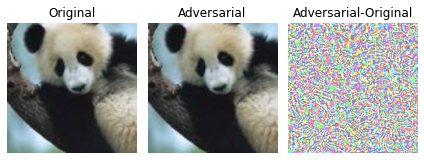

In [41]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
#adv = adv[..., ::-1]  # RGB to BGR
adv = np.clip(adv, 0, 255).astype(np.uint8)

show_images_diff(orig,388,adv,target.data.cpu().numpy()[0])

